# SCOPE OF PROJECT

This project will work on building a commodity prediction algorithm

In [1]:
import math
import pandas_datareader as web
from datetime import datetime
import numpy as np
from pandas_datareader import data as pdr
import yfinance as yfin 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from yahoofinancials import YahooFinancials
import pandas as pd
from keras.models import load_model

# INITIALISING THE TICKER

Before we begin working on building the algorithm we'll first need to initialise the ticker, which will we be using brent crude

In [2]:
#Initialising the Commodities Futures

commodity_futures = ['BZ=F', 'GC=F']

In [3]:
yahoo_financials_commodities = YahooFinancials(commodity_futures)

In [4]:
yfin.pdr_override()

#FOR FUN you can insert a different end date and start date. Note tesla went public on 'June 29, 2010'
#The end date should be best set a day or two before the current day.
start_date = datetime(2008,1,1) #Creating the start date of the range to allow mining the financial data
end_date = datetime(2023,2,28) #End date of the range 

In [5]:
commodity_prices = yahoo_financials_commodities.get_historical_price_data(start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'), 'monthly')

In [6]:
dataframes = {}
for commodity in commodity_futures:
    price_data = commodity_prices[commodity]['prices']
    dataframes[commodity] = pd.DataFrame(price_data)

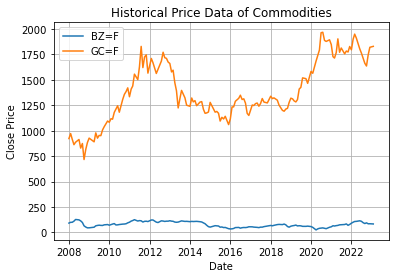

In [7]:
# Loop through the dataframes dictionary and plot the price data for each commodity
for commodity, dataframe in dataframes.items():
    # Convert the 'formatted_date' column to datetime objects
    dataframe['formatted_date'] = pd.to_datetime(dataframe['formatted_date'])

    # Plot the price data
    plt.plot(dataframe['formatted_date'], dataframe['close'], label=commodity)

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Historical Price Data of Commodities')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
#Filtering the 'Close' of both commodities prices

new_dataframes = {}
for commodity in commodity_futures:
    price_data = commodity_prices[commodity]['prices']
    close_price_data = [data['close'] for data in price_data]
    new_dataframes[commodity] = pd.DataFrame(close_price_data, columns=['close'])

# Print the new_dataframes to verify the close prices
for commodity, dataframe in new_dataframes.items():
    print(f"{commodity} close prices:")
    print(dataframe)

BZ=F close prices:
          close
0     92.209999
1    100.099998
2    100.300003
3    111.360001
4    127.779999
..          ...
150   87.959999
151   94.830002
152   85.430000
153   85.910004
154   83.889999

[155 rows x 1 columns]
GC=F close prices:
           close
0     922.700012
1     972.099976
2     916.200012
3     862.799988
4     887.299988
..           ...
150  1662.400024
151  1635.900024
152  1746.000000
153  1819.699951
154  1828.900024

[155 rows x 1 columns]


In [9]:
# Filtering the 'Close' of both commodities prices
new_dataframes = {}
for commodity in commodity_futures:
    price_data = commodity_prices[commodity]['prices']
    close_price_data = [data['close'] for data in price_data]
    new_dataframes[commodity] = pd.DataFrame(close_price_data, columns=['close'])

# Scale the close price data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = {}

for commodity, dataframe in new_dataframes.items():
    close_prices = dataframe['close'].values.reshape(-1, 1)
    scaled_close_prices = scaler.fit_transform(close_prices)
    scaled_data[commodity] = scaled_close_prices

# Create training data for each commodity
training_data = {}
for commodity, data in scaled_data.items():
    # Calculate the training data length (80% of the data)
    training_data_length = math.ceil(len(data) * 0.8)
    
    # Split the data into train and test sets
    train_data = data[0:training_data_length, :]
    
    # Create empty lists for x_train and y_train
    x_train = []
    y_train = []

    # Loop through the train_data and create the x_train and y_train datasets
    for i in range(100, len(train_data)):
        x_train.append(train_data[i-100:i, 0])
        y_train.append(train_data[i, 0])

    # Convert the x_train and y_train lists to numpy arrays
    x_train, y_train = np.array(x_train), np.array(y_train)
        # Reshape the x_train array to have the required dimensions for LSTM input
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


    # Store the training data for the commodity
    training_data[commodity] = {'x_train': x_train, 'y_train': y_train}


In [10]:
for commodity, data in training_data.items():
    x_train = data['x_train']
    y_train = data['y_train']

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(x_train, y_train, batch_size=1, epochs=20)

    # You can save the trained model for each commodity if you want
    model.save(f"{commodity}_model.h5")

Epoch 1/20
24/24 [==============================] - 5s 55ms/step - loss: 0.0363
Epoch 2/20
24/24 [==============================] - 1s 59ms/step - loss: 0.0109
Epoch 3/20
24/24 [==============================] - 1s 52ms/step - loss: 0.0087
Epoch 4/20
24/24 [==============================] - 1s 61ms/step - loss: 0.0083
Epoch 5/20
24/24 [==============================] - 1s 57ms/step - loss: 0.0091
Epoch 6/20
24/24 [==============================] - 1s 58ms/step - loss: 0.0088
Epoch 7/20
24/24 [==============================] - 1s 60ms/step - loss: 0.0091
Epoch 8/20
24/24 [==============================] - 1s 60ms/step - loss: 0.0085
Epoch 9/20
24/24 [==============================] - 1s 60ms/step - loss: 0.0078
Epoch 10/20
24/24 [==============================] - 1s 61ms/step - loss: 0.0088
Epoch 11/20
24/24 [==============================] - 1s 58ms/step - loss: 0.0087
Epoch 12/20
24/24 [==============================] - 1s 59ms/step - loss: 0.0070
Epoch 13/20
24/24 [==================

In [11]:
# Create test data for each commodity
test_data = {}
for commodity, data in scaled_data.items():
    # Calculate the training data length (80% of the data)
    training_data_length = math.ceil(len(data) * 0.8)
    
    # Split the data into test sets
    test_data_raw = data[training_data_length - 100:, :]
    
    # Create empty lists for x_test and y_test
    x_test = []
    y_test = data[training_data_length:, :]
    
    # Loop through the test_data_raw and create the x_test dataset
    for i in range(100, len(test_data_raw)):
        x_test.append(test_data_raw[i-100:i, 0])

    # Convert the x_test list to a numpy array
    x_test = np.array(x_test)

    # Reshape the x_test array to have the required dimensions for LSTM input
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    # Store the test data for the commodity
    test_data[commodity] = {'x_test': x_test, 'y_test': y_test}


In [12]:
# Make predictions for each commodity
predictions_data = {}
for commodity, data in test_data.items():
    x_test = data['x_test']
    y_test = data['y_test']

    # Load the trained model for the commodity
    model = load_model(f"{commodity}_model.h5")

    # Make predictions using the trained model
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)  # Convert the scaled predictions back to original values

    # Calculate the Root Mean Square Error
    RMSE = np.sqrt(np.mean(((predictions - y_test) ** 2)))

    # Store the predictions and RMSE for the commodity
    predictions_data[commodity] = {'predictions': predictions, 'RMSE': RMSE}

In [13]:
for commodity, data in predictions_data.items():
    predictions = data['predictions']
    RMSE = data['RMSE']

    print(f"Predictions for {commodity}:")
    print(predictions)
    print(f"Root Mean Square Error (RMSE) for {commodity}: {RMSE}")
    print("\n")  # Add a newline for better readability

Predictions for BZ=F:
[[1171.7926]
 [1157.2788]
 [1145.326 ]
 [1139.0804]
 [1138.0634]
 [1141.333 ]
 [1145.6733]
 [1149.75  ]
 [1159.3779]
 [1172.7412]
 [1190.5537]
 [1207.3987]
 [1223.1658]
 [1237.1147]
 [1250.1237]
 [1260.7949]
 [1269.0427]
 [1276.3853]
 [1275.7712]
 [1274.13  ]
 [1275.6206]
 [1280.6917]
 [1287.8275]
 [1293.7576]
 [1298.7098]
 [1298.6122]
 [1289.0155]
 [1271.5343]
 [1254.2245]
 [1234.086 ]
 [1214.7286]]
Root Mean Square Error (RMSE) for BZ=F: 1226.1218111595606


Predictions for GC=F:
[[1472.4723]
 [1504.9948]
 [1543.4128]
 [1585.5228]
 [1646.0042]
 [1703.978 ]
 [1738.7615]
 [1755.89  ]
 [1764.0245]
 [1759.2333]
 [1732.022 ]
 [1698.4343]
 [1675.3838]
 [1679.7534]
 [1675.4742]
 [1675.5586]
 [1669.2007]
 [1665.7765]
 [1662.8353]
 [1668.5958]
 [1672.2972]
 [1689.9526]
 [1717.341 ]
 [1738.2582]
 [1737.6836]
 [1722.6392]
 [1696.8301]
 [1663.8671]
 [1630.0615]
 [1617.289 ]
 [1625.5695]]
Root Mean Square Error (RMSE) for GC=F: 1671.1614267223763


